# Diffusion of Gaussians
This notebook outlines the theory behind the diagnostics used to measure diffusitivy in my honours thesis.
They stem from the diffusion of Gaussian initial conditions in one and two dimesnions via the diffusion equation.

The initial condition is set for **tracer concentraiton** however the diagnostics measure the growth rate of the second moment in the one dimensional and two dimensional band case and the growth rate of the area for the two dimensional blob.

## One dimension
In one dimension we start with the initial condition for tracer concentration
$$
\begin{equation*}
    C_{0}(x, t; K) = \frac{1}{\sqrt{4\pi Kt}}\exp\Big(-\frac{x^2}{4Kt}\Big),
\end{equation*}
$$
which is then diffused by the diffusion equation
$$
\begin{equation*}
    \frac{\partial C}{\partial t} = K\frac{\partial^2 C}{\partial x^2}.
\end{equation*}
$$
Here $x(t)$ is the position of the tracer at time $t$ and it is the second moment for $x(t)$ that we show grows linearly with time.
This corresponds to the mean squared displacement of a piece of tracer growing linearly with time.

I will put the full working for this into the thesis so just say that we have the result
$$
\begin{equation*}
    \frac{\langle x^2 \rangle}{\int c(x)dx} = \frac{\sigma_{x}^{2}}{\int c(x)dx} = 2Kt \approx \frac{(\frac{\Delta x}{2})^2 \sum_{i = 1}^{N}i^2C_{i}}{\sum_{i = 1}^{N}C_{i}}
\end{equation*}
$$
where the data from a tracer experiment has been ordered from **highest concentration to lowest concentration**.

To verify that this diagnostic does give linear growth of the second moment and can predict a diffusivity we run a diffusion of a Gaussian in one dimension using the same spectral methods that will be used when in the presence of the QG flow.

### Setting up the simulation
First we setup the problem using the `PassiveTracerFlows.jl` package and write a function to plot the output.
The workspace must first be activated.

In [1]:
using Pkg
Pkg.activate(".")

  Activating new environment at `~/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/Project.toml`


In [2]:
using PassiveTracerFlows, Distributions, Plots

These are the parameters for the simulations run in this notebook.
**If a parameter is changed be sure to re-run all necessary cells before running a simulaiton.**

In [31]:
dev = CPU() 
nx, ny = 64, 1            
stepper = "RK4"         
dt = 0.002          
nsteps = 7000            
nsubs  = 50  
Lx, Ly = 16, 1
κ = 0.25
uvel(x, y) = 1
vvel(x, y) = 0

vvel (generic function with 1 method)

Now setup a one dimensional advection diffusion problem from the `PassiveTracerFlows` package.

In [32]:
prob_1d = TracerAdvectionDiffusion.Problem(dev; nx=nx, ny=ny, Lx=Lx, Ly = Ly, κ=κ,
                                        #steadyflow=true, u=uvel, v=vvel,
                                        dt=dt, stepper=stepper)
sol, clock, vars, params = prob_1d.sol, prob_1d.clock, prob_1d.vars, prob_1d.params
xgrid, ygrid = prob_1d.grid.x, prob_1d.grid.y

C₀ = Array{Float64}(undef, prob_1d.grid.nx, prob_1d.grid.ny)
for i in 1:prob_1d.grid.ny
    C₀[:, i] = pdf(Normal(0, 1), xgrid)
end
set_c!(prob_1d, C₀)

In [13]:
function plot_output(prob)
	
	l = @layout Plots.grid(2, 1)
  	p = plot(layout=l, size = (800, 700))
	
	c = prob.vars.c
	grid = prob.grid
	x, y = grid.x, grid.y
	
	plot!(p[1], x, c,
			 legend = :false,
			 xlims = (-grid.Lx/2, grid.Lx/2),
			 xlabel = "x",
			 ylabel = "concentration",
			  title = "Diffusion of Gaussian initial condition in one dimension",
		 framestyle = :box)
	
	t = prob.clock.t
	sorted_concentration = sort(reshape(c, :), rev = true)
	plot!(p[2], 1:length(sorted_concentration), sorted_concentration,
			label = false,
			xlabel = "Grid cell",
			ylabel = "Concentration",
			title = "Concentration ~ grid cell",
			ylims = (0, findmax(sorted_concentration)[1]),
			color = :green)

	return p
	
end

plot_output (generic function with 1 method)

### Diagnostic
Now code the diagnostic up, have used `k` for indexing rather than `i` but **this `k` is not realated to the diffusion that is being estimated.**

In [14]:
function second_mom(prob::FourierFlows.Problem)
	
	C = reshape(prob.vars.c, :)
	sort!(C, rev = true)
	N = length(C)
	
	Δx = prob.grid.Lx / prob.grid.nx
	
	Σk²Cₖ = (Δx / 2)^2 * sum( [ k^2 * C[k] for k ∈ 1:N ] )
	ΣCₖ = sum(C)
	
	return Σk²Cₖ/ΣCₖ
	
end

second_mom (generic function with 1 method)

Now step the problem forwards and compute the diagnostic at each step. 
Currently the plot does not work here, I will try and sort this out

In [33]:
startwalltime = time()

	p = plot_output(prob_1d)
	
	second_mom1d = Vector{Float64}(undef, round(Int, nsteps/nsubs) + 1)
	second_mom1d[1] = second_mom(prob_1d)
	tvec_1d = Vector{Float64}(undef, round(Int, nsteps/nsubs) + 1)
	tvec_1d[1] = clock.t

	anim = @animate for j = 0:round(Int, nsteps/nsubs)

	  p[1][1][:y] = vars.c
	  p[1][:title] = "Concentration, t=" * string(clock.t)
	  p[2][1][:y] = sort(reshape(vars.c, :), rev = true)
	
	  second_mom1d[j + 1] = second_mom(prob_1d)
	  tvec_1d[j + 1] = clock.t

	  stepforward!(prob_1d, nsubs)
	  TracerAdvectionDiffusion.updatevars!(prob_1d)
	end

	mp4(anim, "1D_gaussiandiff.mp4", fps=12)

┌ Info: Saved animation to 
│   fn = /Users/Joey/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/1D_gaussiandiff.mp4
└ @ Plots /Users/Joey/.julia/packages/Plots/avj9X/src/animation.jl:104


Plots.AnimatedGif("/Users/Joey/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/1D_gaussiandiff.mp4")

### Looking at second moment and computing diffusivity
We have saved second moments from this simulation that we can plot.

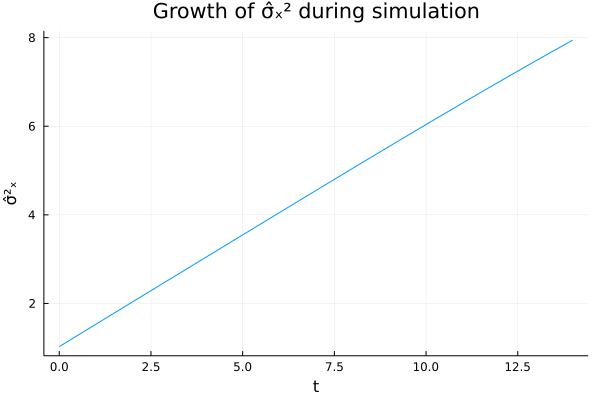

In [34]:
oneddiffplot = plot(tvec_1d, second_mom1d, label = false, xlabel = "t", ylabel = "σ̂²ₓ", title = "Growth of σ̂ₓ² during simulation")
oneddiffplot

In [17]:
savefig(oneddiffplot, "oneddiffplot.png")

The linear growth suggests we have constant diffusivity which we now calculate using
$$
\begin{equation*}
    K = \frac{\Delta\hat{\sigma}_{x}^{2}}{2\Delta t}.
\end{equation*}
$$

In [35]:
Δσ²_1d = second_mom1d[end] - second_mom1d[1]
Δt_1d = tvec_1d[end] - tvec_1d[1]
K1d = Δσ²_1d / (2 * Δt_1d)

0.2471474571015464

Here we see that this is very good approximation to the parameterised value of $\kappa = 0.25$ that was set in the simulation problem.

## Two dimensions
In two dimesions we consider two initial conditions of tracer concentration, a "Gaussian blob" and a "Gaussian band".
As they are different distribtuions they require different diagnostics.
The band will use something similar to the one dimensional case but will only look at the **growing of the meridional second moment** $\hat{\sigma}_{y}^{2}$.
Currently this is not fully operational so will get the blob simulation in and return to the band.

The blob will look at the growth of the area of circle with radius equal to the radial second moment $\hat{\sigma}_{r}^{2}$ or $\langle r^2 \rangle$.

### Gaussian blob simulation
Here the initial condition for tracer concentration is
$$
\begin{equation*}
    C_{0}(x, y, t; K) = \frac{1}{4\pi Kt}\exp-\Big(\frac{r^2}{4Kt} \Big).
\end{equation*}
$$
Again I bypass the theory and jump to the result that the area of a circle will grow linearly and this is again estimated by ordering the concnetration data from highest to lowest 
$$
\begin{equation*}
    \frac{\langle A \rangle}{\int C(A)dA} = 4\pi K t \approx \frac{\Delta x \Delta y \sum_{i = 1}^{N}i C_{i}}{\sum_{i = 1}^{N}C_{i}}
\end{equation*}
$$
Now setup a simulation, plot function and the function to calculate the average area for a diffusion simulation of a Gaussian blob.

In [19]:
prob_2d = TracerAdvectionDiffusion.Problem(dev; nx=nx, Lx=Lx, κ=κ,
                                                #steadyflow=true, u=uvel, v=vvel,
                                                dt=dt, stepper=stepper)
strip = Normal(0, 1)
strip_IC(x) = pdf(strip, x)
C₀2d = Array{Float64}(undef, prob_2d.grid.nx, prob_2d.grid.ny)
xgrid2d, ygrid2d = prob_2d.grid.x, prob_2d.grid.y

#Gaussian blob
C₀2d = [pdf(MvNormal([0, 0], [1 0;0 1]), [x, y]) for y in ygrid2d, x in xgrid2d]
set_c!(prob_2d, C₀2d)

In [20]:
function plot_output_2d(prob)
  	
	l = @layout Plots.grid(2, 1)
  	p = plot(layout=l, size = (1000, 600))
	
	c = prob.vars.c
  	grid = prob.grid
	x, y = grid.x, grid.y
	
  	heatmap!(p[1], x, y, c',
			 aspectratio = 1,
				  c = :balance,
		   colorbar = true,
			 legend = :false,
			  xlims = (-grid.Lx/2, grid.Lx/2),
			  ylims = (-grid.Ly/2, grid.Ly/2),
			 xlabel = "x",
			 ylabel = "y",
			  title = "Blob advection-diffusion",
		 framestyle = :box)
	
	t = prob.clock.t
	sorted_concentration = sort(reshape(c, :), rev = true)
	plot!(p[2], 1:length(sorted_concentration), sorted_concentration,
			label = false,
			xlabel = "Grid cell",
			ylabel = "Concentration",
			title = "Concentration ~ grid cell",
			ylims = (0, findmax(sorted_concentration)[1]),
			color = :green)
	
	return p
end

plot_output_2d (generic function with 1 method)

In [21]:
function first_mom(prob::FourierFlows.Problem)
	
	C = reshape(prob.vars.c, :)
	sort!(C, rev = true)
	N = length(C)
	
	Δx = prob.grid.Lx / prob.grid.nx
	Δy = prob.grid.Ly / prob.grid.ny
	
	ΣkCₖ = (Δx * Δy) * sum( [ k * C[k] for k ∈ 1:N ] )
	ΣCₖ = sum(C)
	
	
	return ΣkCₖ/ΣCₖ
	
end

first_mom (generic function with 1 method)

In [22]:
p_2d = plot_output_2d(prob_2d)
	
first_mom2d = Vector{Float64}(undef, round(Int, nsteps/nsubs) + 1)
first_mom2d[1] = first_mom(prob_2d)
tvec_2d = Vector{Float64}(undef, round(Int, nsteps/nsubs) + 1)
tvec_2d[1] = prob_2d.clock.t

anim_2d = @animate for j = 0:round(Int, nsteps/nsubs)

    p_2d[1][1][:z] = prob_2d.vars.c
    p_2d[1][:title] = "Concentration, t=" * string(prob_2d.clock.t)
    p_2d[2][1][:y] =  sort(reshape(prob_2d.vars.c, :), rev = true)

    first_mom2d[j + 1] = first_mom(prob_2d)
    tvec_2d[j + 1] = prob_2d.clock.t
    
    stepforward!(prob_2d, nsubs)
    TracerAdvectionDiffusion.updatevars!(prob_2d)
end

mp4(anim_2d, "2d_gaussiandiff_blob.mp4", fps=12)

┌ Info: Saved animation to 
│   fn = /Users/Joey/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/2d_gaussiandiff_blob.mp4
└ @ Plots /Users/Joey/.julia/packages/Plots/avj9X/src/animation.jl:104


Plots.AnimatedGif("/Users/Joey/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/2d_gaussiandiff_blob.mp4")

Now look at the growth of the average area and if it is linear as the theory suggests we calculate the diffusivity by 
$$
\begin{equation*}
    K = \frac{\Delta \langle A \rangle}{4 \pi \Delta t}
\end{equation*}
$$

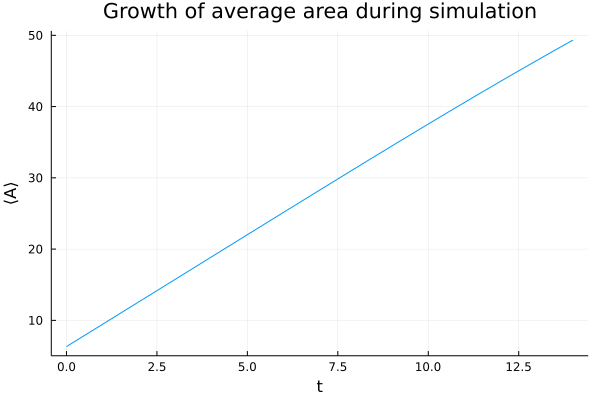

In [23]:
twoddiffplot = plot(tvec_2d, first_mom2d, label = false, xlabel = "t", ylabel = "⟨A⟩", title = "Growth of average area during simulation")
twoddiffplot

In [24]:
Δt_2d = tvec_2d[end] - tvec_2d[1]
Δ𝔼A2d = first_mom2d[end] - first_mom2d[1]
K2d_blob = Δ𝔼A2d / (4 * π * Δt_2d) 

0.2445166689082563

In [25]:
savefig(twoddiffplot, "twoddiffplot.png")

Again we see that the diffusion calculated is a very good estimation to the diffusion set in the problme $\kappa = 0.25$.

## Gaussian band simulation
To look at the band we reset the two dimensional problem to have the initial condition and run the simulation using this.
**Be sure to rerun correct cells prior to running simulaitons!**.

In the case for the band to measure a diffusivity we look to the meridional second moment $\sigma_{y}^{2}$.
This will be done much the same as in the one dimensional case though must divide by the width of the domain so as to only get the meridional dispersion of tracer.

In [26]:
prob_2d = TracerAdvectionDiffusion.Problem(dev; nx=nx, Lx=Lx, κ=κ,
                                                #steadyflow=true, u=uvel, v=vvel,
                                                dt=dt, stepper=stepper)
strip = Normal(0, 1)
strip_IC(x) = pdf(strip, x)
C₀2d = Array{Float64}(undef, prob_2d.grid.nx, prob_2d.grid.ny)
xgrid2d, ygrid2d = prob_2d.grid.x, prob_2d.grid.y

for i in 1:prob_2d.grid.ny
C₀2d[i, :] = pdf(Normal(0, 1), ygrid2d)
end

set_c!(prob_2d, C₀2d)

In [27]:
function second_mom_2d(prob::FourierFlows.Problem)
	
    meridional_diff = Array{Float64}(undef, prob.grid.nx)

    for j ∈ 1:prob.grid.nx
        C = reshape(prob.vars.c[j, :], :)
        sort!(C, rev = true)
        N = length(C)
        
        Δy = prob.grid.Ly / prob.grid.ny
        
        Σk²Cₖ = (Δy / 2)^2 * sum( [ k^2 * C[k] for k ∈ 1:N ] )
        meridional_diff[j] = Σk²Cₖ
    end
	C = reshape(prob.vars.c, :)
    ΣCₖ = sum(C)
	return sum(meridional_diff) / ΣCₖ 
	
end

second_mom_2d (generic function with 1 method)

In [28]:
p_2d = plot_output_2d(prob_2d)
	
second_mom2d = Vector{Float64}(undef, round(Int, nsteps/nsubs) + 1)
second_mom2d[1] = second_mom_2d(prob_2d)
tvec_2d = Vector{Float64}(undef, round(Int, nsteps/nsubs) + 1)
tvec_2d[1] = prob_2d.clock.t

anim_2d = @animate for j = 0:round(Int, nsteps/nsubs)

    p_2d[1][1][:z] = prob_2d.vars.c
    p_2d[1][:title] = "Concentration, t=" * string(prob_2d.clock.t)
    p_2d[2][1][:y] =  sort(reshape(prob_2d.vars.c, :), rev = true)

    second_mom2d[j + 1] = second_mom_2d(prob_2d)
    tvec_2d[j + 1] = prob_2d.clock.t
    
    stepforward!(prob_2d, nsubs)
    TracerAdvectionDiffusion.updatevars!(prob_2d)
end

mp4(anim_2d, "2d_gaussiandiff_strip.mp4", fps=12)

┌ Info: Saved animation to 
│   fn = /Users/Joey/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/2d_gaussiandiff_strip.mp4
└ @ Plots /Users/Joey/.julia/packages/Plots/avj9X/src/animation.jl:104


Plots.AnimatedGif("/Users/Joey/Desktop/ThesisCode/QG_tracer_advection/Honours thesis/Gaussian diffusion/2d_gaussiandiff_strip.mp4")

Again we look to find a linear relationship and use this to estimate the diffusivity.

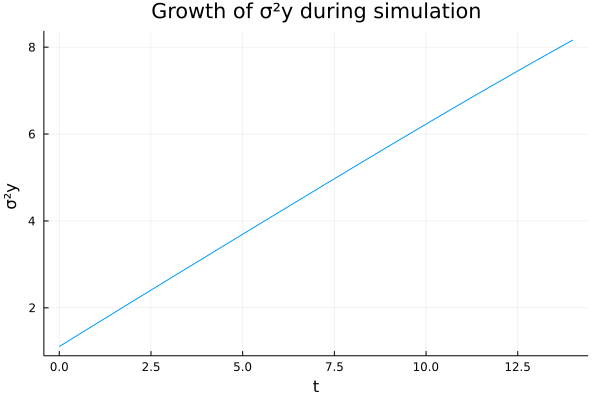

In [29]:
twoddband = plot(tvec_2d, second_mom2d, label = false, xlabel = "t", ylabel = "σ²y ", title = "Growth of σ²y during simulation")
savefig(twoddband, "twodband.png")
twoddband

In [30]:
Δσ²_2d = second_mom2d[end] - second_mom2d[1]
Δt_2d = tvec_2d[end] - tvec_2d[1]
K2d_band = (Δσ²_2d) / (2 * Δt_2d)

0.2519854164172307